In [1]:
"""
File: XGBoost.ipynb
Code to train and evaluate an XGBoost model on MIMIC-IV FHIR dataset.
"""


def Project():
    """
    __Objectives__
    0. Import data and separate unique visit tokens
    1. Reduce the number of features (manual selection, hierarchy aggregation)
    2. Create frequency features from event tokens
    3. Include num_visits, youngest and oldest age, and maybe time
    4. Use label column to create the prediction objective
    5. Train XGBoost model and evaluate on test dataset

    __Questions__
    0. Why does CEHR-BERT only have 512 possible concept and time tokens? -> Probably most tokens are not present in the sample

    __Extra__
    Hyperparameters: {learning rate (LR), maximum tree depth (max depth), number of estimators (n estimators),
                      column sampling by tree (colsample), row subsampling (subsample) and the regulation parameter α.}
    """
    return ProjectObjectives.__doc__

In [2]:
import os

ROOT = "/fs01/home/afallah/odyssey/odyssey"
os.chdir(ROOT)
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import (
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
)
from scipy.sparse import csr_matrix, hstack, vstack, save_npz, load_npz

from tqdm import tqdm

%matplotlib inline

DATA_ROOT = f"{ROOT}/data"
DATA_PATH = f"{DATA_ROOT}/patient_sequences.parquet"
SAMPLE_DATA_PATH = f"{DATA_ROOT}/CEHR-BERT_sample_patient_sequence.parquet"
FREQ_DF_PATH = f"{DATA_ROOT}/patient_feature_freq.csv"
FREQ_MATRIX_PATH = f"{DATA_ROOT}/patient_freq_matrix.npz"

In [3]:
# Load data
data = pd.read_parquet(DATA_PATH)
data

,patient_id,num_visits,label,death_after_start,death_after_end,length,token_length,new_start,event_tokens,event_tokens_updated,age_tokens,time_tokens,visit_tokens,position_tokens
0,be7990af-3829-5df0-b552-c397a71d46fe,3,0,NaN,NaN,217,225,NaN,"[VS, 4443, 00338004304, 00006473900, 000935211...","[VS, 4443, 00338004304, 00006473900, 000935211...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 6...","[8000, 8000, 8000, 8000, 8000, 8000, 8000, 800...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,877d281b-676b-53ab-9911-1e4677989f6f,1,0,NaN,NaN,18,20,NaN,"[VS, 741, 00182864389, 00904585461, 0070345020...","[VS, 741, 00182864389, 00904585461, 0070345020...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...","[5085, 5085, 5085, 5085, 5085, 5085, 5085, 508...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,65ae1ba2-dede-53a4-80be-3d0666b27e87,1,0,NaN,NaN,40,42,NaN,"[VS, 51248_2, 51736_2, 51244_3, 51222_4, 51737...","[VS, 51248_2, 51736_2, 51244_3, 51222_4, 51737...","[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2...","[8787, 8787, 8787, 8787, 8787, 8787, 8787, 878...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,aa1446f6-dbc4-5734-9645-a1e01a7ba6f0,1,0,NaN,NaN,18,20,NaN,"[VS, 0689, 33332000801, 00056017075, 655970103...","[VS, 0689, 33332000801, 00056017075, 655970103...","[77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 7...","[4853, 4853, 4853, 4853, 4853, 4853, 4853, 485...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,b3c303cc-df8c-5789-80f0-83f1c319b813,1,1,22.0,17.0,81,83,NaN,"[VS, 7935, 00338067104, 00054855324, 009045165...","[VS, 7935, 00338067104, 00054855324, 009045165...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[6037, 6037, 6037, 6037, 6037, 6037, 6037, 603...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90273,88ae054e-0173-5049-b067-a67bad1aeee9,1,0,NaN,NaN,36,38,NaN,"[VS, 7931, 00075062041, 00023050601, 005363381...","[VS, 7931, 00075062041, 00023050601, 005363381...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[8788, 8788, 8788, 8788, 8788, 8788, 8788, 878...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
90274,3b6ec88d-59a8-5833-8977-48e8b58211b1,1,0,NaN,NaN,17,19,NaN,"[VS, 00338067104, 51079045620, 66553000401, 00...","[VS, 00338067104, 51079045620, 66553000401, 00...","[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 6...","[5353, 5353, 5353, 5353, 5353, 5353, 5353, 535...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
90275,b883470b-664e-5f0e-b38c-717cd5b07b84,1,1,3.0,0.0,152,154,NaN,"[VS, 5503, 00338004904, 00006494300, 001828447...","[VS, 5503, 00338004904, 00006494300, 001828447...","[81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 8...","[7450, 7450, 7450, 7450, 7450, 7450, 7450, 745...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
90277,c946654b-2765-5dc1-8cd4-9865d3c84d30,2,0,NaN,NaN,46,51,NaN,"[VS, 51079088120, 51079088120, 68084025401, 00...","[VS, 51079088120, 51079088120, 68084025401, 00...","[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 4...","[4850, 4850, 4850, 4850, 4850, 4850, 4850, 485...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [4]:
# Find the unique set of all possible tokens, including special tokens
unique_event_tokens = set()

for patient_event_tokens in tqdm(
    data["event_tokens_updated"].values, desc="Loading Tokens", unit=" Patients"
):
    for event_token in patient_event_tokens:
        unique_event_tokens.add(event_token)

unique_event_tokens = list(unique_event_tokens)
unique_event_tokens.sort(reverse=True)

print(
    f"Complete list of unique event tokens\nLength: {len(unique_event_tokens)}\nHead: {unique_event_tokens[:10]}..."
)

Loading Tokens: 100%|██████████| 173671/173671 [00:10<00:00, 17241.55 Patients/s]

Complete list of unique event tokens
Length: 17909
Head: ['[PAD]', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043B3', 'XW04351', 'XW03372', 'XW03331', 'X2RF432', 'X2RF332']...


In [5]:
print(unique_event_tokens)

['[PAD]', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043B3', 'XW04351', 'XW03372', 'XW03331', 'X2RF432', 'X2RF332', 'X2RF032', 'X2C1361', 'X2C0361', 'X2A5312', 'W_3', 'W_2', 'W_1', 'W_0', 'VS', 'VE', 'M_9', 'M_8', 'M_7', 'M_6', 'M_5', 'M_4', 'M_3', 'M_2', 'M_12', 'M_11', 'M_10', 'M_1', 'M_0', 'LT', 'HZ99ZZZ', 'HZ87ZZZ', 'HZ85ZZZ', 'HZ81ZZZ', 'HZ2ZZZZ', 'GZB4ZZZ', 'GZB3ZZZ', 'GZB2ZZZ', 'GZB0ZZZ', 'GZ3ZZZZ', 'F01L5ZZ', 'DWY67ZZ', 'DWY27ZZ', 'DW21JZZ', 'DW21DZZ', 'DW1698Z', 'DW061ZZ', 'DW041ZZ', 'DW031ZZ', 'DW021ZZ', 'DW013ZZ', 'DW011ZZ', 'DV20JZZ', 'DV011ZZ', 'DV001ZZ', 'DU119YZ', 'DU1198Z', 'DU021ZZ', 'DU011ZZ', 'DT021ZZ', 'DPYC7ZZ', 'DPY67ZZ', 'DP0C3ZZ', 'DP0C2ZZ', 'DP0C1ZZ', 'DP0B1ZZ', 'DP091ZZ', 'DP081ZZ', 'DP073ZZ', 'DP061ZZ', 'DP051ZZ', 'DP041ZZ', 'DP001ZZ', 'DM011ZZ', 'DM001ZZ', 'DHY37ZZ', 'DH0B1ZZ', 'DH073ZZ', 'DH041ZZ', 'DG22DZZ', 'DG021ZZ', 'DF23JZZ', 'DF23DZZ', 'DF034ZZ', 'DF031ZZ', 'DDY17ZZ', 'DD071ZZ', 'DD021ZZ', 'DD011ZZ', 'DD001ZZ', 'DBY27ZZ', 'DB22DZZ', 'DB071ZZ', 'DB061ZZ', 'DB

In [6]:
special_tokens = [
    "[PAD]",
    "VS",
    "VE",
    "W_0",
    "W_1",
    "W_2",
    "W_3",
    *[f"M_{i}" for i in range(0, 13)],
    "LT",
]
feature_event_tokens = ["id"] + [
    token for token in unique_event_tokens if token not in special_tokens
]
feature_event_tokens

['id',
 'XY0VX83',
 'XW0DXR5',
 'XW0DX82',
 'XW043B3',
 'XW04351',
 'XW03372',
 'XW03331',
 'X2RF432',
 'X2RF332',
 'X2RF032',
 'X2C1361',
 'X2C0361',
 'X2A5312',
 'HZ99ZZZ',
 'HZ87ZZZ',
 'HZ85ZZZ',
 'HZ81ZZZ',
 'HZ2ZZZZ',
 'GZB4ZZZ',
 'GZB3ZZZ',
 'GZB2ZZZ',
 'GZB0ZZZ',
 'GZ3ZZZZ',
 'F01L5ZZ',
 'DWY67ZZ',
 'DWY27ZZ',
 'DW21JZZ',
 'DW21DZZ',
 'DW1698Z',
 'DW061ZZ',
 'DW041ZZ',
 'DW031ZZ',
 'DW021ZZ',
 'DW013ZZ',
 'DW011ZZ',
 'DV20JZZ',
 'DV011ZZ',
 'DV001ZZ',
 'DU119YZ',
 'DU1198Z',
 'DU021ZZ',
 'DU011ZZ',
 'DT021ZZ',
 'DPYC7ZZ',
 'DPY67ZZ',
 'DP0C3ZZ',
 'DP0C2ZZ',
 'DP0C1ZZ',
 'DP0B1ZZ',
 'DP091ZZ',
 'DP081ZZ',
 'DP073ZZ',
 'DP061ZZ',
 'DP051ZZ',
 'DP041ZZ',
 'DP001ZZ',
 'DM011ZZ',
 'DM001ZZ',
 'DHY37ZZ',
 'DH0B1ZZ',
 'DH073ZZ',
 'DH041ZZ',
 'DG22DZZ',
 'DG021ZZ',
 'DF23JZZ',
 'DF23DZZ',
 'DF034ZZ',
 'DF031ZZ',
 'DDY17ZZ',
 'DD071ZZ',
 'DD021ZZ',
 'DD011ZZ',
 'DD001ZZ',
 'DBY27ZZ',
 'DB22DZZ',
 'DB071ZZ',
 'DB061ZZ',
 'DB024ZZ',
 'DB021ZZ',
 'D90F1ZZ',
 'D9031ZZ',
 'D8001ZZ',
 'D7071ZZ

In [7]:
###  Get and save frequencies of each token for each patient sequence.  ###

patient_freq_matrix = None
buffer_size = 50000
df_buffer = []
matrix_buffer = []


for idx, patient in tqdm(data.iterrows(), desc="Loading Tokens", unit=" Patients"):
    patient_history = {token: 0 for token in feature_event_tokens}
    patient_history["id"] = idx

    for event_token in patient["event_tokens_updated"]:
        if event_token not in special_tokens:
            patient_history[event_token] += 1

    matrix_buffer.append(list(patient_history.values()))

    if len(matrix_buffer) >= buffer_size:
        current_matrix = csr_matrix(
            matrix_buffer, shape=(len(matrix_buffer), len(feature_event_tokens))
        )

        if patient_freq_matrix is None:
            patient_freq_matrix = current_matrix
        else:
            patient_freq_matrix = vstack(
                [patient_freq_matrix, current_matrix], format="csr"
            )

        matrix_buffer = []


if matrix_buffer:
    current_matrix = csr_matrix(
        matrix_buffer, shape=(len(matrix_buffer), len(feature_event_tokens))
    )

    if patient_freq_matrix is None:
        patient_freq_matrix = current_matrix
    else:
        patient_freq_matrix = vstack(
            [patient_freq_matrix, current_matrix], format="csr"
        )

    matrix_buffer = []


save_npz(FREQ_MATRIX_PATH, patient_freq_matrix)
print(f"Save & Done! Final Matrix Shape: {patient_freq_matrix.shape}")

Loading Tokens: 173671 Patients [07:05, 408.46 Patients/s]


Save & Done! Final Matrix Shape: (173671, 17889)


In [8]:
# Load frequency matrix
# patient_freq_matrix = load_npz(FREQ_MATRIX_PATH)
num_patients = patient_freq_matrix.shape[0]
patient_freq_matrix

<173671x17889 sparse matrix of type '<class 'numpy.int64'>'
	with 15603061 stored elements in Compressed Sparse Row format>

In [10]:
def find_min_greater_than_zero(lst):
    positive_numbers = np.array(lst)[np.array(lst) > 0]

    if len(positive_numbers) == 0:
        return 0

    min_positive = np.min(positive_numbers)
    return min_positive


# Get extra features
num_visits = data["num_visits"].values
min_age = [
    find_min_greater_than_zero(patient_age_tokens)
    for patient_age_tokens in data["age_tokens"]
]
max_age = [np.max(patient_age_tokens) for patient_age_tokens in data["age_tokens"]]

# Add extra features to the frequency dataset
patient_freq_matrix = hstack(
    [patient_freq_matrix, csr_matrix([num_visits, min_age, max_age]).T], format="csr"
)
patient_freq_matrix = patient_freq_matrix[:, 1:]  # Drop id feature
patient_freq_matrix

<173671x17891 sparse matrix of type '<class 'numpy.int64'>'
	with 15950405 stored elements in Compressed Sparse Row format>

In [11]:
# Get intuition about the frequency of different features in the dataset
report_threshold = 50
features_above_threshold = np.sum(
    (patient_freq_matrix.getnnz(axis=0) > report_threshold).astype(int)
)
print(
    f"How many features have been reported for at least {report_threshold} patients?\n{features_above_threshold} Features"
)

# Plot the histogram of feature frequency
# plt.hist(patient_freq_matrix.getnnz(axis=0), bins=range(num_patients+1), edgecolor='black')
# plt.xlabel('Number of Nonzero Rows')
# plt.ylabel('Number of Columns')
# plt.title('Histogram of Nonzero Rows per Column')
# plt.show()

How many features have been reported for at least 50 patients?
4722 Features


In [12]:
# Pick features to train the model on
NUM_FEATURES = 10000
features_sorted_by_freq = np.argsort(-patient_freq_matrix.getnnz(axis=0))
selected_features = features_sorted_by_freq[: NUM_FEATURES + 1]
selected_features

array([17890, 17889, 17888, ...,  1535,  8284,  8110])

In [35]:
# Define custom labels, here death in 12 M
data["label"] = (
    (data["death_after_end"] == 0) & (data["death_after_end"] <= 180)
).astype(int)

print(f"Total positive labels: {sum(data['label'])} out of {len(data)}")

Total positive labels: 9215 out of 173671


In [36]:
# Prepare data for model training
X = patient_freq_matrix[:, selected_features]
Y = data["label"].values

# Optional, Scale features. Didn't improve performance
# scaler = MaxAbsScaler()
# X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=1
)

In [37]:
# Single XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=23)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=23, ...)

Balanced Accuracy
Train: 0.93607  |  Test: 0.83123  |  All Data: 0.91510

F1 Score
Train: 0.91451  |  Test: 0.73478  |  All Data: 0.87985

Precision
Train: 0.95865  |  Test: 0.81168  |  All Data: 0.93149

Recall
Train: 0.87425  |  Test: 0.67119  |  All Data: 0.83364

AUROC
Train: 0.93607  |  Test: 0.83123  |  All Data: 0.91510

AUC-PR
Train: 0.91979  |  Test: 0.75016  |  All Data: 0.88698

Average Precision Score
Train: 0.84478  |  Test: 0.56224  |  All Data: 0.78536



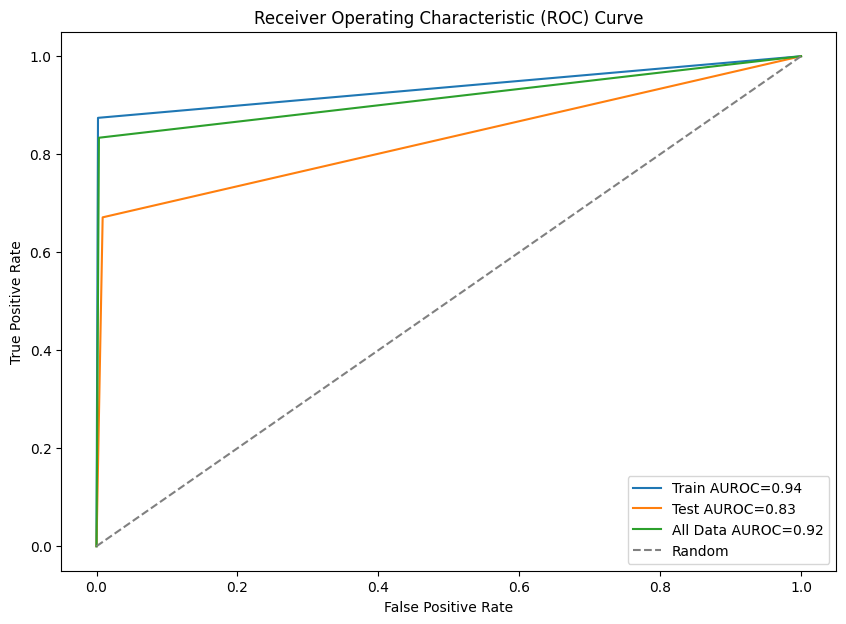

In [38]:
### ASSESS MODEL PERFORMANCE ###

# Predict labels for train, test, and all data
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
all_data_pred = xgb_model.predict(X)

# Balanced Accuracy
y_train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
y_test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
all_data_accuracy = balanced_accuracy_score(Y, all_data_pred)

# F1 Score
y_train_f1 = f1_score(y_train, y_train_pred)
y_test_f1 = f1_score(y_test, y_test_pred)
all_data_f1 = f1_score(Y, all_data_pred)

# Precision
y_train_precision = precision_score(y_train, y_train_pred)
y_test_precision = precision_score(y_test, y_test_pred)
all_data_precision = precision_score(Y, all_data_pred)

# Recall
y_train_recall = recall_score(y_train, y_train_pred)
y_test_recall = recall_score(y_test, y_test_pred)
all_data_recall = recall_score(Y, all_data_pred)

# AUROC
y_train_auroc = roc_auc_score(y_train, y_train_pred)
y_test_auroc = roc_auc_score(y_test, y_test_pred)
all_data_auroc = roc_auc_score(Y, all_data_pred)

# AUC-PR (Area Under the Precision-Recall Curve)
y_train_p, y_train_r, _ = precision_recall_curve(y_train, y_train_pred)
y_test_p, y_test_r, _ = precision_recall_curve(y_test, y_test_pred)
all_data_p, all_data_r, _ = precision_recall_curve(Y, all_data_pred)

y_train_auc_pr = auc(y_train_r, y_train_p)
y_test_auc_pr = auc(y_test_r, y_test_p)
all_data_auc_pr = auc(all_data_r, all_data_p)

# Average Precision Score (APS)
y_train_aps = average_precision_score(y_train, y_train_pred)
y_test_aps = average_precision_score(y_test, y_test_pred)
all_data_aps = average_precision_score(Y, all_data_pred)

# Print Metrics
print(
    f"Balanced Accuracy\nTrain: {y_train_accuracy:.5f}  |  Test: {y_test_accuracy:.5f}  |  All Data: {all_data_accuracy:.5f}\n"
)
print(
    f"F1 Score\nTrain: {y_train_f1:.5f}  |  Test: {y_test_f1:.5f}  |  All Data: {all_data_f1:.5f}\n"
)
print(
    f"Precision\nTrain: {y_train_precision:.5f}  |  Test: {y_test_precision:.5f}  |  All Data: {all_data_precision:.5f}\n"
)
print(
    f"Recall\nTrain: {y_train_recall:.5f}  |  Test: {y_test_recall:.5f}  |  All Data: {all_data_recall:.5f}\n"
)
print(
    f"AUROC\nTrain: {y_train_auroc:.5f}  |  Test: {y_test_auroc:.5f}  |  All Data: {all_data_auroc:.5f}\n"
)
print(
    f"AUC-PR\nTrain: {y_train_auc_pr:.5f}  |  Test: {y_test_auc_pr:.5f}  |  All Data: {all_data_auc_pr:.5f}\n"
)
print(
    f"Average Precision Score\nTrain: {y_train_aps:.5f}  |  Test: {y_test_aps:.5f}  |  All Data: {all_data_aps:.5f}\n"
)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
fpr_all_data, tpr_all_data, _ = roc_curve(Y, all_data_pred)

# Plot Information
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f"Train AUROC={y_train_auroc:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUROC={y_test_auroc:.2f}")
plt.plot(fpr_all_data, tpr_all_data, label=f"All Data AUROC={all_data_auroc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

In [41]:
### Assess which features are the most important

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a list of tuples (feature, importance) and sort it by importance in descending order
sorted_importances = sorted(zip(selected_features, feature_importances), key=lambda x: x[1], reverse=True)

# Display the top 10 most important features
top_features = sorted_importances[:10]
for feature, importance in top_features:
    print(f"{feature}: {importance}")

6143: 0.05417247116565704
6058: 0.03238081932067871
7966: 0.027305852621793747
6064: 0.027035918086767197
5855: 0.01691002957522869
16591: 0.013835983350872993
6057: 0.013668525032699108
16940: 0.013095570728182793
5366: 0.012564348056912422
6093: 0.012086514383554459


In [ ]:
### SCRIPT FOR K-FOLD VALIDATION ###
N_FOLDS = 10

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precisions = []
recalls = []
aurocs = []
auc_prs = []
average_precision_scores = []

# Perform k-fold cross-validation
for train_index, test_index in tqdm(
    stratified_kfold.split(X, Y), desc=f"{N_FOLDS}-Fold Validation", unit=" Model(s)"
):
    # Get the relevant train and test data
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = Y[train_index], Y[test_index]

    # Create a new XGBoost model for each fold
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=23)

    # Train the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = xgb_model.predict(X_test_fold)

    # Calculate performance metrics
    accuracy_fold = balanced_accuracy_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold)
    recall_fold = recall_score(y_test_fold, y_pred_fold)
    auroc_fold = roc_auc_score(y_test_fold, y_pred_fold)
    p_fold, r_fold, _ = precision_recall_curve(y_test_fold, y_pred_fold)
    auc_pr_fold = auc(r_fold, p_fold)
    average_precision_score_fold = average_precision_score(y_test_fold, y_pred_fold)

    # Append metrics to lists
    accuracy_scores.append(accuracy_fold)
    f1_scores.append(f1_fold)
    precisions.append(precision_fold)
    recalls.append(recall_fold)
    aurocs.append(auroc_fold)
    auc_prs.append(auc_pr_fold)
    average_precision_scores.append(average_precision_score_fold)

# Print average metrics across all folds
print(f"Average Balanced Accuracy: {sum(accuracy_scores) / N_FOLDS:.5f}")
print(f"Average F1 Score: {sum(f1_scores) / N_FOLDS:.5f}")
print(f"Average Precision: {sum(precisions) / N_FOLDS:.5f}")
print(f"Average Recall: {sum(recalls) / N_FOLDS:.5f}")
print(f"Average AUROC: {sum(aurocs) / N_FOLDS:.5f}")
print(f"Average AUC-PR: {sum(auc_prs) / N_FOLDS:.5f}")
print(f"Average Precision Score: {sum(average_precision_scores) / N_FOLDS:.5f}")